In [114]:
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
import math
import copy
import matplotlib.pyplot as plt
import wandb
import os

## Load data

In [151]:
data = pickle.load(open(r'../Data/deltaQ_cycles.pkl', 'rb'))

In [231]:
y = np.zeros(124)

x = np.zeros((124, 30, 3))
for i, cell in enumerate(data.keys()):
    x[i, :, 0] = data[cell]["DeltaQ_logVars"][19:]
    x[i, :, 1] = np.log10(-data[cell]["DeltaQ_mins"][19:])
    x[i, :, 2] = data[cell]["DeltaQ_means"][19:]
    y[i] = np.log10(data[cell]["cycle_life"])

In [232]:
# convert to tensors and concatenate features and labels
x = torch.Tensor(x)
y = torch.Tensor(y)

In [154]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  5,  7,  9, 11, 13, 15, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123])

In [297]:
train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
test = TensorDataset(torch.Tensor(x[test_ind]),torch.Tensor(y[test_ind]))
stest = TensorDataset(torch.Tensor(x[secondary_ind]),torch.Tensor(y[secondary_ind]))

## Transformer Model

In [156]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=1024):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.pe = nn.Parameter(torch.empty(max_len, 1, d_model))  # requires_grad automatically set to True
        nn.init.uniform_(self.pe, -0.02, 0.02)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [179]:
class FullModel(torch.nn.Module):

    def __init__(self, feat_dim, max_len, d_model, n_heads, num_layers, dim_feedforward,
                 dropout=0.0, freeze=False):
        super(FullModel, self).__init__()

        self.max_len = max_len
        self.d_model = d_model
        self.n_heads = n_heads

        self.project_inp = nn.Linear(feat_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, dropout=dropout*(1.0 - freeze), max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(d_model, self.n_heads, dim_feedforward, dropout*(1.0 - freeze))
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        self.dropout1 = nn.Dropout(dropout)

        self.feat_dim = feat_dim
        self.output_layer = self.build_output_module(d_model, max_len)

    def build_output_module(self, d_model, max_len):
        output_layer = nn.Linear(d_model * max_len, 1)
        return output_layer

    def forward(self, X):
        """
        Args:
            X: (batch_size, seq_length, feat_dim) torch tensor of masked features (input)
        Returns:
            output: (batch_size, num_classes)
        """

        # permute because pytorch convention for transformers is [seq_length, batch_size, feat_dim]. padding_masks [batch_size, feat_dim]
        inp = X.permute(1, 0, 2)
        inp = self.project_inp(inp) * math.sqrt(
            self.d_model)  # [seq_length, batch_size, d_model] project input vectors to d_model dimensional space
        inp = self.pos_enc(inp)  # add positional encoding
        output = self.transformer_encoder(inp)  # (seq_length, batch_size, d_model)
        #output = self.act(output)  # the output transformer encoder/decoder embeddings don't include non-linearity
        output = output.permute(1, 0, 2)  # (batch_size, seq_length, d_model)
        #output = self.dropout1(output)

        # Output
        output = output.reshape(output.shape[0], -1)  # (batch_size, seq_length * d_model)
        output = self.output_layer(output)  # (batch_size, num_classes)

        return output

## Train

In [294]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

feat_dim = 3
max_len = 30
d_model = 12
dim_feedforward = 12
num_layers = 2
n_heads = 1
dropout = 0.0

nepoch = 300
batch_size = 1
lr = 0.0001

In [159]:
os.environ['WANDB_NOTEBOOK_NAME'] = "transformer_multivariate.ipynb"

In [270]:
wandb.init(
    # set the wandb project where this run will be logged
    project="rips_toyota",
    name="transformer_karena_8", 
    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "epochs": nepoch,
    "architecture": "transformer multivariate",
    "features": "partial logVar(DeltaQ), logmin(DeltaQ), mean(DeltaQ) timeseries",
    "target": "loglifetime",
    "d_model": d_model,
    "num_layers": num_layers,
    "num_heads": n_heads,
    "dropout": dropout,
    "batch_size": batch_size
    }
)

In [295]:
# Load nodel, loss function, and optimizer
model = FullModel(feat_dim=feat_dim, max_len=max_len, d_model=d_model, n_heads=n_heads,
                  num_layers=num_layers, dim_feedforward=dim_feedforward, dropout=dropout).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


model.train()

# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer.zero_grad()
        train_input, train_label = batch
        output = model(train_input.to(device))
        loss = criterion(10**output, 10**train_label)
        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()

    for cell in test_batched:
        test_input, test_label = cell
        test_output = model(test_input.to(device))
        test_loss = criterion(10**test_output, 10**test_label)

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label = cell
        stest_output = model(stest_input.to(device))
        stest_loss = criterion(10**stest_output, 10**stest_label)
        

        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%10 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

#wandb.finish()

c:\Users\kyan3\miniconda3\envs\toyota\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epochs: 10 | rmse:  316.500 | rmse_test:  555.638 | rmse_stest:  563.142
Epochs: 20 | rmse:  328.509 | rmse_test:  407.946 | rmse_stest:  440.162
Epochs: 30 | rmse:  300.357 | rmse_test:  381.187 | rmse_stest:  417.129
Epochs: 40 | rmse:  300.078 | rmse_test:  456.368 | rmse_stest:  473.639
Epochs: 50 | rmse:  283.033 | rmse_test:  451.963 | rmse_stest:  467.904
Epochs: 60 | rmse:  305.416 | rmse_test:  428.040 | rmse_stest:  446.322
Epochs: 70 | rmse:  258.636 | rmse_test:  563.962 | rmse_stest:  563.977
Epochs: 80 | rmse:  245.463 | rmse_test:  370.880 | rmse_stest:  396.402
Epochs: 90 | rmse:  295.839 | rmse_test:  589.499 | rmse_stest:  586.827
Epochs: 100 | rmse:  230.399 | rmse_test:  364.457 | rmse_stest:  384.317
Epochs: 110 | rmse:  211.895 | rmse_test:  372.057 | rmse_stest:  386.848
Epochs: 120 | rmse:  217.502 | rmse_test:  403.068 | rmse_stest:  411.171
Epochs: 130 | rmse:  204.111 | rmse_test:  289.340 | rmse_stest:  316.120
Epochs: 140 | rmse:  208.688 | rmse_test:  338.

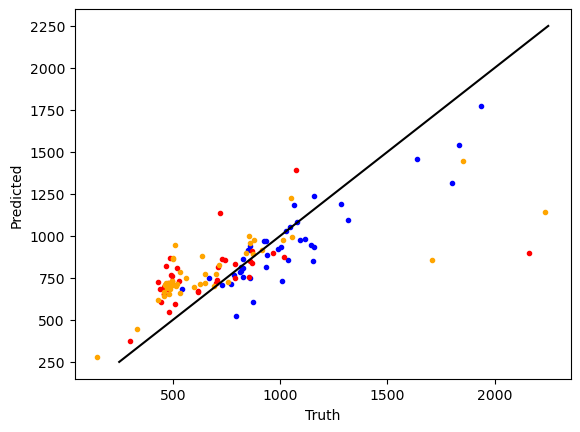

In [296]:
fig,ax = plt.subplots()
colors = ["blue","red","orange"]
for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label = cell
        predicted.append(10**model(input[None,:].to(device)).detach().numpy()[0,0])
        labels.append(10**label)

    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")